In [1]:
%pip install datasets
%pip install tensorflow
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


## RNN with BI-LSTM

In [2]:
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

2024-04-26 05:03:50.997299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 05:04:10.784813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import numpy as np
import tensorflow as tf
from datasets import load_dataset

# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")

# Extract training and test data
train_data = dataset["train"]
test_data = dataset["test"]

# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_data["tokens"])

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(train_data["tokens"])
test_sequences = tokenizer.texts_to_sequences(test_data["tokens"])

# Pad sequences
max_sequence_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)

# Convert POS tags and NER tags to one-hot encodings
train_pos_tags = train_data["pos_tags"]
train_ner_tags = train_data["ner_tags"]
test_pos_tags = test_data["pos_tags"]
test_ner_tags = test_data["ner_tags"]

# Flatten the list of lists
flat_pos_tags = [tag for sublist in train_pos_tags + test_pos_tags for tag in sublist]
flat_ner_tags = [tag for sublist in train_ner_tags + test_ner_tags for tag in sublist]

# Get unique POS and NER tags
unique_pos_tags = set(flat_pos_tags)
unique_ner_tags = set(flat_ner_tags)

# Create dictionaries for mapping tags to integers and vice versa
pos_tag_to_int = {tag: i for i, tag in enumerate(unique_pos_tags)}
ner_tag_to_int = {tag: i for i, tag in enumerate(unique_ner_tags)}
int_to_pos_tag = {i: tag for tag, i in pos_tag_to_int.items()}
int_to_ner_tag = {i: tag for tag, i in ner_tag_to_int.items()}

# Convert tags to integers
train_pos_tags_int = [[pos_tag_to_int[tag] for tag in seq] for seq in train_pos_tags]
train_ner_tags_int = [[ner_tag_to_int[tag] for tag in seq] for seq in train_ner_tags]
test_pos_tags_int = [[pos_tag_to_int[tag] for tag in seq] for seq in test_pos_tags]
test_ner_tags_int = [[ner_tag_to_int[tag] for tag in seq] for seq in test_ner_tags]

# Pad tag sequences
train_pos_tags_padded = tf.keras.preprocessing.sequence.pad_sequences(train_pos_tags_int, maxlen=max_sequence_length)
train_ner_tags_padded = tf.keras.preprocessing.sequence.pad_sequences(train_ner_tags_int, maxlen=max_sequence_length)
test_pos_tags_padded = tf.keras.preprocessing.sequence.pad_sequences(test_pos_tags_int, maxlen=max_sequence_length)
test_ner_tags_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ner_tags_int, maxlen=max_sequence_length)

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(unique_ner_tags), activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode NER tags
train_ner_tags_one_hot = tf.keras.utils.to_categorical(train_ner_tags_padded, num_classes=len(unique_ner_tags))

# Train the model
model.fit(train_sequences, train_ner_tags_one_hot, epochs=10, batch_size=32)

# Evaluate the model on the test data
test_ner_tags_one_hot = tf.keras.utils.to_categorical(test_ner_tags_padded, num_classes=len(unique_ner_tags))
test_loss, test_accuracy = model.evaluate(test_sequences, test_ner_tags_one_hot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10


/user/HS400/ms04010/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-04-26 05:04:41.277242: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.9415 - loss: 0.3712
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9798 - loss: 0.0761
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.9797 - loss: 0.0681
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.9801 - loss: 0.0597
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.9814 - loss: 0.0488
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9861 - loss: 0.0396
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.9895 - loss: 0.0307
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.9928 - loss: 0.0228
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9954 - loss: 0.0164
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9967 - loss: 0.0129
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9703 - loss: 0.2292
Test Loss: 0.21765995025634766
Test Accuracy: 0.9710839986801147


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step


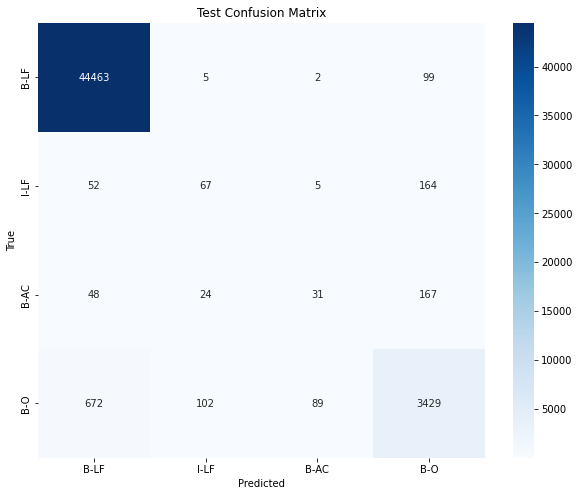

Test Classification Report:
              precision    recall  f1-score   support

        B-LF       0.98      1.00      0.99     44569
        I-LF       0.34      0.23      0.28       288
        B-AC       0.24      0.11      0.16       270
         B-O       0.89      0.80      0.84      4292

    accuracy                           0.97     49419
   macro avg       0.61      0.54      0.57     49419
weighted avg       0.97      0.97      0.97     49419



In [4]:
# Predict NER tags for test data
test_predicted = model.predict(test_sequences)

# Convert test predictions and true labels back to categorical values
test_predicted_labels = np.argmax(test_predicted, axis=-1)
test_true_labels = test_ner_tags_padded

# Flatten the test arrays
test_predicted_labels_flat = test_predicted_labels.flatten()
test_true_labels_flat = test_true_labels.flatten()

# Create test confusion matrix
test_cm = confusion_matrix(test_true_labels_flat, test_predicted_labels_flat)

# Plot test confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_ner_tags, yticklabels=unique_ner_tags)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Test Classification Report
print("Test Classification Report:")
print(classification_report(test_true_labels_flat, test_predicted_labels_flat, target_names=unique_ner_tags))


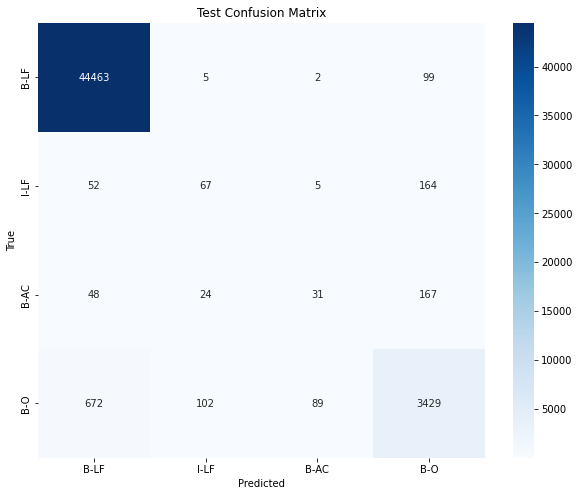

In [5]:
# Plot test confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_ner_tags, yticklabels=unique_ner_tags)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

## RNN with albert

In [6]:
from transformers import AlbertTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch

# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset["train"]
test_data = dataset["test"]

# Initialize tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Map pos_tags and ner_tags to indices
pos_tag_vocab = {tag: idx for idx, tag in enumerate(sorted(set(sum(train_data['pos_tags'], []))))}
ner_tag_vocab = {tag: idx for idx, tag in enumerate(sorted(set(sum(train_data['ner_tags'], []))))}

def encode(examples):
    tokenized_inputs = tokenizer(examples['tokens'], is_split_into_words=True, truncation=True, padding='max_length', max_length=128)
    max_len = 128
    # Convert and pad ner_tags and pos_tags
    tokenized_inputs['ner_tags'] = [[ner_tag_vocab[tag] for tag in tags] + [-100] * (max_len - len(tags)) for tags in examples['ner_tags']]
    tokenized_inputs['pos_tags'] = [[pos_tag_vocab[tag] for tag in tags] + [-100] * (max_len - len(tags)) for tags in examples['pos_tags']]
    return tokenized_inputs


/user/HS400/ms04010/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
# Apply the function and prepare datasets
train_data = train_data.map(encode, batched=True)
test_data = test_data.map(encode, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ner_tags', 'pos_tags'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ner_tags', 'pos_tags'])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [8]:
import torch
from torch import nn
from transformers import AlbertModel

# Model definition
class AlbertRNN(nn.Module):
    def __init__(self, num_pos_tags, num_ner_tags):
        super(AlbertRNN, self).__init__()
        self.albert = AlbertModel.from_pretrained('albert-base-v2')
        self.rnn = nn.GRU(input_size=768, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        self.fc_ner = nn.Linear(512, num_ner_tags)
        self.fc_pos = nn.Linear(512, num_pos_tags)

    def forward(self, input_ids, attention_mask):
        encoded_layers = self.albert(input_ids, attention_mask=attention_mask)[0]
        rnn_output, _ = self.rnn(encoded_layers)
        ner_output = self.fc_ner(rnn_output)
        pos_output = self.fc_pos(rnn_output)
        return ner_output, pos_output

/user/HS400/ms04010/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/user/HS400/ms04010/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [9]:
# Instantiate the model
num_pos_tags = len(pos_tag_vocab)
num_ner_tags = len(ner_tag_vocab)
model = AlbertRNN(num_pos_tags, num_ner_tags)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)

    # Padding ner_tags and pos_tags to the maximum length in the batch
    ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
    pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'ner_tags': ner_tags, 'pos_tags': pos_tags}

# Update DataLoader with the custom collate function
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [11]:
def train(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            optimizer.zero_grad()
            ner_output, pos_output = model(input_ids, attention_mask)

            # Flatten the outputs and labels
            ner_output = ner_output.view(-1, ner_output.shape[-1])  # Shape: (batch_size * sequence_length, num_ner_tags)
            pos_output = pos_output.view(-1, pos_output.shape[-1])  # Shape: (batch_size * sequence_length, num_pos_tags)
            ner_tags = ner_tags.view(-1)  # Shape: (batch_size * sequence_length)
            pos_tags = pos_tags.view(-1)  # Shape: (batch_size * sequence_length)

            # Calculate losses and sum them
            ner_loss = criterion(ner_output, ner_tags)
            pos_loss = criterion(pos_output, pos_tags)
            loss = ner_loss + pos_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

/tmp/ipykernel_533599/1977488790.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
/tmp/ipykernel_533599/1977488790.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)


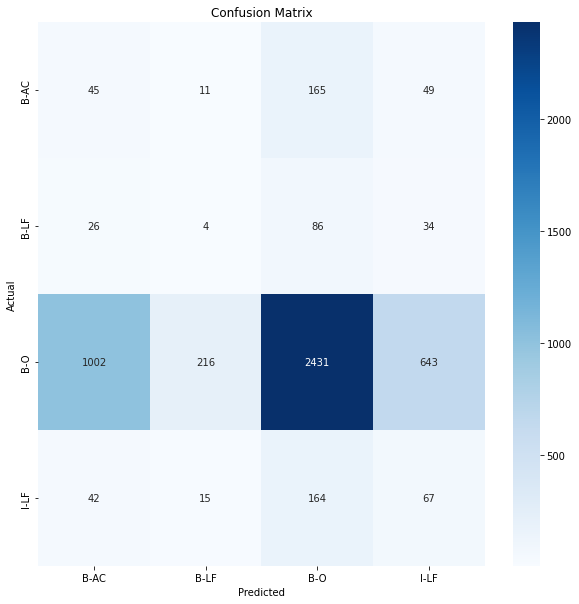

In [12]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            ner_output, pos_output = model(input_ids, attention_mask)
            ner_preds = torch.argmax(ner_output, dim=-1).view(-1)  # Flatten output
            ner_tags = ner_tags.view(-1)  # Flatten true labels

            # Filter out padding values
            mask = ner_tags != -100
            ner_preds = ner_preds[mask]
            ner_tags = ner_tags[mask]

            all_preds.extend(ner_preds.tolist())
            all_true.extend(ner_tags.tolist())

    return all_true, all_preds

# Collect all predictions and true values
true_labels, predictions = evaluate_model(model, test_loader)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(ner_tag_vocab.keys()), yticklabels=list(ner_tag_vocab.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


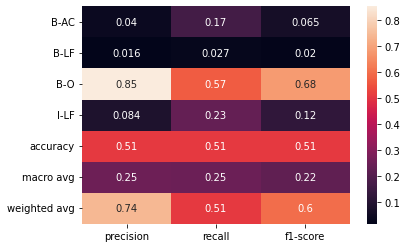

In [13]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming true_labels and predictions have been collected from the model
report = classification_report(true_labels, predictions, target_names=list(ner_tag_vocab.keys()), output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()
